# Water security project for Modern Data Analytics 

In the following code cell I will import all the necessary packages

In [107]:
# Data processing
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Models
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import graphviz
from graphviz import Source


## 1. United Nations UN water data

#### 1.1 Data fetching

Using the United Nations Water webpage, we can build a dataframe that brings global indicators regarding social, economical and enviromental indicators. Even if the webpage is itself an interactive map, we can make use of the API that the browser uses to get the data. By taking a look at how the browser would make use of the API, we would do it the same way by changing some parameters. Later, we would analyze the data using the tools reviewed in the lectures

In [56]:
# 6.1.1 Proportion of population using safely managed drinking water services
url = "https://www.sdg6data.org/handle-ajax-callback"

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:103.0) Gecko/20100101 Firefox/103.0",
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.5",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    "X-Requested-With": "XMLHttpRequest",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origin"
}

indicators = [
    ("79_80", "0.00", "3,850.49", "stress"),  # Water stress
    # Renewable water resources in billion cubic meters per year
    ("135_137_138", "0.00", "8,647.00", "renewable"),
    # Degree of integrated water resources management implementation (0-100)
    ("82_83", "0.00", "100.00", "mngmt"),
    # Gross domestic product per capita
    ("483_508", "731.06", "112,226.90", "gdp"),
    # Proportion of population with access to electricity
    ("483_503", "0.00", "100.0", "elec"),
    ("485_499", "0.00", "100.00", "agr"),  # Agricultural land (% of land area)
    # CO2 emissions, tonnes per capita
    ("485_501", "0.00", "33.75", "emission")
]


The following function will receive 4 arguments to build a __df__. It will create the _body_ needed for the request and it will return the __df__ with the information by country

In [57]:
def generate_df(indicator, min_bound, max_bound, col_name):
    r"""
    So after taking a look at the API that the UN Water uses to get the data, it asks for the values regarding the locations, the number of the indicator and the ranges.
    Given that the URL and the headers are the same, there are a few parameters that change between each request

    Keyword arguments:
    indicator -- is like the id of the indicator desired to be fetch
    min_bound -- is the minimum value possible to get. In the website it is possible to filter by this value
    max_bound -- is the maximum value possible to get. In the website it is possible to filter by this value
    col_name -- is the name of the column in the pd.DataFrame
    """

    body = f"allRegion%5B%5D=World--World&allRegion%5B%5D=Geographical+region--Latin+America+and+the+Caribbean&allRegion%5B%5D=Geographical+region--Asia&allRegion%5B%5D=Geographical+region--Europe&allRegion%5B%5D=Geographical+region--Northern+Africa&allRegion%5B%5D=Geographical+region--Northern+America&allRegion%5B%5D=Geographical+region--Oceania&allRegion%5B%5D=Geographical+region--Sub-Saharan+Africa&indicators%5B%5D={indicator}&ranges%5B0%5D%5B%5D={min_bound}&ranges%5B0%5D%5B%5D={max_bound}"
    req = requests.post(url, headers=headers, data=body)
    data = req.json()["commonCountriesDataTable"]
    df = pd.DataFrame()
    df["country"] = data.keys()
    df[col_name] = data.values()
    return df


_indicators_ will be looped using the function created and it will be joined to a first __df__ created using the _water stress_ variable given that it is an important variable for the analysis. The result will be a dataframe with 9 variable of 179 countries

In [58]:
ind, min, max, col_name = indicators[0]
df = generate_df(ind, min, max, col_name)

for ind, min, max, col_name in indicators[1:]:
    df_1 = generate_df(ind, min, max, col_name)
    df = pd.merge(df, df_1, how="left", on=["country", "country"])


After fetching the data, we look at the dataset to see the variables, its type and how many missing values are in each column.

In [59]:
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    179 non-null    object
 1   stress     179 non-null    object
 2   renewable  177 non-null    object
 3   mngmt      170 non-null    object
 4   gdp        174 non-null    object
 5   elec       178 non-null    object
 6   agr        178 non-null    object
 7   emission   177 non-null    object
dtypes: object(8)
memory usage: 12.6+ KB


(None,
   country    stress renewable  mngmt        gdp    elec    agr emission
 0     AFG     54.76     65.33  12.00   1,970.56   97.70  58.08     0.20
 1     AGO      1.87    148.40  61.00   6,110.27   45.67  45.68     0.89
 2     ALB      6.80     30.20  47.00  13,192.44  100.00  42.85     1.94
 3     ARE  1,630.67      0.15  79.00  63,299.42  100.00   5.38    20.80
 4     ARG     10.46    876.20  38.00  19,690.66  100.00  54.36     3.99)

Using the _info_ function, we can see that all the columns are type object, so it is necessary to convert to numeric. Also, for 3 variables de thousands separator should be removed. Also, we can see that the variables do not have considerable missing values, so it is easier to assess this issue with data imputation

In [60]:
# Cast the variables as float except the country
for col in df.columns[1:]:
    if col in ["stress", "renewable", "gdp"]:
        df[col] = df[col].str.replace(',', '').astype(float)
    else:
        df[col] = df[col].astype(float)


In [61]:
# Fill in the missing values using the mean of the column
for col in df.columns[2:]:
    df[col] = df[col].fillna(df[col].mean())


In [62]:
# To determine a high index of water stress, a threshold of 40% has been arbitrarily chosen amongst the scientific water resources modelling community. This will be our target variable in our model
# https://rdmc.nottingham.ac.uk/bitstream/handle/internal/188/Geography%20sustainability.old/23_how_can_water_stress_be_calculated.html

df["high"] = df["stress"] > 40


In [63]:
df.to_csv("dataset.csv", index=None)
# df = pd.read_csv("dataset.csv")


#### 1.2 Model

This is what we are going to do:
1. Fit a decision tree to try to understand who can we classify future data to avoid high stress on water. This way we can see what factors are determinant for high water stress
2. Fit a random forest and boosting to try to improve our tree and calculate ROC for both

3. With the water org that professor suggested, do NLP to try to see what cities are doing regarding water stress

4. Wait for a 10 and celebrate

Based on our research question, the goal is to understand the factors that would lead to a high water stree index on how a country can prevent it from beign in such a situation.

In [89]:
# First define X and Y data to fit the model. We take the independent columns that we think might determine the water stress.
X = df.iloc[:, 2:8].values
y = df["high"]

# Create and instance of a decision tree and fit the model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)


In [90]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df.columns[2:8],
                                class_names=["high", "low"],
                                filled=True, rounded=True,
                                special_characters=True)

graph = Source(dot_data)
graph.format = 'png'
graph.render('water_stress_tree', view=True)


'water_stress_tree.png'

From the tree, we can see that the amount of water resources is key to have a low water stress index. This is one of the most important advantage of decision tress, that they are easy to interpret. For example, if a country gets below 5.31 billion cubic metric of renewable water resources, it will be an indication that it might get high water stress problem. But it is now the only indicator, even if it has high water resources, it needs to have a not to high gpd, probably because more production needs more water and that could lead to water depletion, and so on. Also having low proportion of agricultural land is an indicator of low water stress. That can be explained by the amounts of water needed to feed animals used for production.

Now we have an idea of what can determine a high water stress, but it necessary to know how good the model performs. For this, we will apply a train-test split to assess the accuracy of the model. With the train data we will generate the tree and with the test we will predict for new data and see how well it does

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

# Create Decision Tree classifer object
clf = tree.DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7037037037037037


It seems that the accuracy is not too bad for new data, but we can improve the model by using a differente creiterion than _gini_, so we will try _entropy_, and to restrict the depth of the tree so we can get a less overfitted model

In [93]:
# Create Decision Tree classifer object
clf_opt = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf_opt = clf_opt.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf_opt.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7407407407407407


This last tree seems to be doing pretty well, and we can see that some variable like _gdp_ are not that important compared to the tree without validation. This last tree is quite easy to understand and to get insights, which can help to understand and classify when a country has high water stress

In [88]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df.columns[2:8],
                                class_names=["high", "low"],
                                filled=True, rounded=True,
                                special_characters=True)

graph = Source(dot_data)
graph.format = 'png'
graph.render('water_stress_tree_opt', view=True)


'water_stress_tree_opt.png'

Although, decision trees can be biased and sensitive to variations, so to try to improve the model some options are available to reduce the variance and the bias. To get a better model, we will implement a random forest and boosting models. The advantage of this models is that they are based on decision trees, so the approach is similar and can generate better results given its robustness and accuracy, but the problem is that the interpretation is not that easy as a single tree and it can be slow to compute

First, we fit the random forest

In [97]:
# Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=rf.predict(X_test)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8148148148148148


One of the advantages of random forests is that we can see how important is each feature by taking a look at the node impurity decrease averaged over all trees of the ensemble. From the importance score index, as we saw in the optimized decision tree, we can see the amount of renewable resources and the proportion of land used in agriculture are important to determine a high level of water stress.

In [100]:
feature_imp = pd.Series(rf.feature_importances_,
                        index=df.columns[2:8]).sort_values(ascending=False)
feature_imp


renewable    0.249369
agr          0.190578
emission     0.167606
gdp          0.157641
mngmt        0.136132
elec         0.098674
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


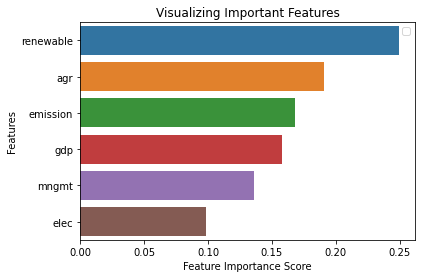

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


By determining the most important features in a random forest ensemble, we can fit a model with the top features and see if the accuracy can be improved

In [106]:
X_feat = df[['renewable', 'agr', 'emission']]  # Removed feature "sepal length"
y_feat = df['high']

# Split dataset into training set and test set
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.70, random_state=5)  # 70% training and 30% test


In [105]:
from sklearn import metrics
clf_feat = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_feat.fit(X_train_feat, y_train_feat)

# prediction on test set
y_pred_feat = clf_feat.predict(X_test_feat)

# Import scikit-learn metrics module for accuracy calculation
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test_feat, y_pred_feat))


Accuracy: 0.7857142857142857


Unfortunately, the metric is not improving but decreasing, so its better to use the first random forest estimated
Now we will try gradient boosting. This approach train a decision tree and based on the results it trains a second tree to try to improve the metrics. Like Random Forests, it uses many trees but a difference is that this approach is better at reducing the bias, meanwhile Random Forests is better at reducing variance. After fitting the model we its clear that the performance is not too good, and that using a random forest is a better approach.

In [108]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)


0.6851851851851852

#### 1.3 Conclusion

In order to determine what can cause a high water stress index, we collected data from the UN Water database for 2019 and analyzed it using decision trees approach. We started using a single tree to see what are the most relevant factors, and later we implemented ensemble models like random forests and gradient boosting. Based on the metrics, it is clear that the RF approach was better in generalizing new data and it was a more robust approach than using a single tree.

From our analysis, we can see that mantaining healthy water resources management, not using too much of agrucltural land and limiting the national production can be a way to maintain a low water stress index.

2.2 Cities water risk

In [111]:
df_2017_risk = pd.read_csv("data/2017_Cities_Water_Risks.csv")
df_2018_risk = pd.read_csv("data/2018_Cities_Water_Risks.csv")
df_2017_actions = pd.read_csv("data/2017_-_Cities_Water_Actions.csv")
df_2018_actions = pd.read_csv("data/2018_-_Cities_Water_Actions.csv")


In [119]:
for df in [df_2017_risk, df_2018_risk, df_2017_actions, df_2018_actions]:
      print(df.shape[0], len(df["Account No"].unique()))

709 308
608 271
625 285
685 255


In [122]:
df_2017_risk[df_2017_risk["Account No"]==54100]

,Account No,Organisation,City,Country,Region,Access,C40,Reporting year,Risks to city’s water supply,​Timescale,Magnitude,Risk description,Current population,Population year,City location,Country location
0,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Flooding,NaN,NaN,NaN,119098,2017,"(38.951705, -92.334072)","(37.09024, -95.712891)"
110,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Declining water quality,Medium-term,Less serious,The McBaine wells are somewhat susceptible to ...,119098,2017,"(38.951705, -92.334072)","(37.09024, -95.712891)"
111,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Declining water quality,NaN,NaN,NaN,119098,2017,"(38.951705, -92.334072)","(37.09024, -95.712891)"
112,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Declining water quality,NaN,NaN,NaN,119098,2017,"(38.951705, -92.334072)","(37.09024, -95.712891)"
343,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Inadequate or aging infrastructure,Medium-term,Serious,There is not enough infrastructure to meet fut...,119098,2017,"(38.951705, -92.334072)","(37.09024, -95.712891)"
543,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Increased water stress or scarcity,Medium-term,Serious,The current supply is adequate for present nee...,119098,2017,"(38.951705, -92.334072)","(37.09024, -95.712891)"


In [123]:
df_2017_actions[df_2017_actions["Account No"]==54100]

,Account No,Organisation,City,Country,Region,Access,C40,Reporting year,Risks to city's water supply,​Adaptation action,Action description,City Location,Country Location
427,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Increased water stress or scarcity,Conservation awareness and education,Actions under consideration (currently seeking...,"(38.951705, -92.334072)","(37.09024, -95.712891)"
428,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Declining water quality,Watershed preservation,We must exercise caution with regard to land u...,"(38.951705, -92.334072)","(37.09024, -95.712891)"
429,54100,"City of Columbia, MO","Columbia, MO",USA,North America,Public,NaN,2017,Inadequate or aging infrastructure,Investment in existing water supply infrastruc...,Actions under consideration: \n\nAlternatives ...,"(38.951705, -92.334072)","(37.09024, -95.712891)"
